# **Regresión multivariable**

*Nuestra tarea consiste en predecir el valor medio de las viviendas en los distritos californianos, dada una serie de características de estos distritos.*

**Etapas**:
* Obtención de los datos
* Estudio de los datos
* Descubriendo y visualizando datos
* Preparando los datos para el modelo
* Seleccionar los modelos y entrenarlos
* Evaluar los resultados



# Inicio

En primer lugar, vamos a importar algunos módulos comunes, asegurarnos de que MatplotLib traza las figuras correctamente y preparar una función para guardar las figuras. También comprobamos que Python 3.5 o posterior está instalado (aunque Python 2.x puede funcionar, está obsoleto por lo que es **altamente** recomendable utilizar Python 3 en su lugar), así como Scikit-Learn ≥0.20.

In [33]:
# Se requiere Python ≥ 3.5
import sys;
assert sys.version_info >= (3, 5);

# Se requiere Scikit-Learn ≥ 0.20
import sklearn;
assert sklearn.__version__ >= "0.20";

# Otros imports
import numpy as np;
import os;

# lo que sigue, sólo en Google Colab
%matplotlib inline

# Más imports
import matplotlib as mpl;
import matplotlib.pyplot as plt;

# tamaño del texto en las etiquetas por defecto
mpl.rc('axes',  labelsize=14);
mpl.rc('xtick', labelsize=12);
mpl.rc('ytick', labelsize=12);


# Obteniendo los datos

## Descargando los datos

Los datos vamos a descargarlos desde un servicio remoto. El github de Aurélien Gerón, autor del libro "*Aprende Machine Learning con Scikit-Learn, Keras y Tensorflow*".

In [34]:
import tarfile;
import urllib.request;

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/";
HOUSING_PATH = os.path.join("datasets", "housing");
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz";

# esta función descarga y descomprime los datos desde una url a un directorio
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path);
    tgz_path = os.path.join(housing_path, "housing.tgz");
    urllib.request.urlretrieve(housing_url, tgz_path);
    housing_tgz = tarfile.open(tgz_path);
    housing_tgz.extractall(path=housing_path);
    housing_tgz.close();

In [35]:
# Y llamamos a la función recién creada para descargar los datos
fetch_housing_data();

In [36]:
import pandas as pd

# Creamos una función que lee el fichreo .csv que acabamos de bajar y descomprimir

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv");
    return pd.read_csv(csv_path);


## Primer acercamiento a la estructura de los datos

Cargamos los datos en memoria y hacemos un primer análisis.

In [37]:
housing = load_housing_data();
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [38]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Observa arriba

* Tenemos columnas con datos **null**: $total\_bedrooms$ tiene menos datos *non-null* que el resto.
* La columna $ocean\_proximity$ no es de tipo numérico (tipo $string$).

Vamos a mirar en esta última, el número de valores distintos.

In [39]:
housing["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

Respecto al resto de columnas, vamos a describirlas mediante un análisis estadístico simple.

In [40]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Finalmente, para este apartado, vamos a visualizar la distribución de los valores de las columnas numéricas.

Observa los picos *extraños*.

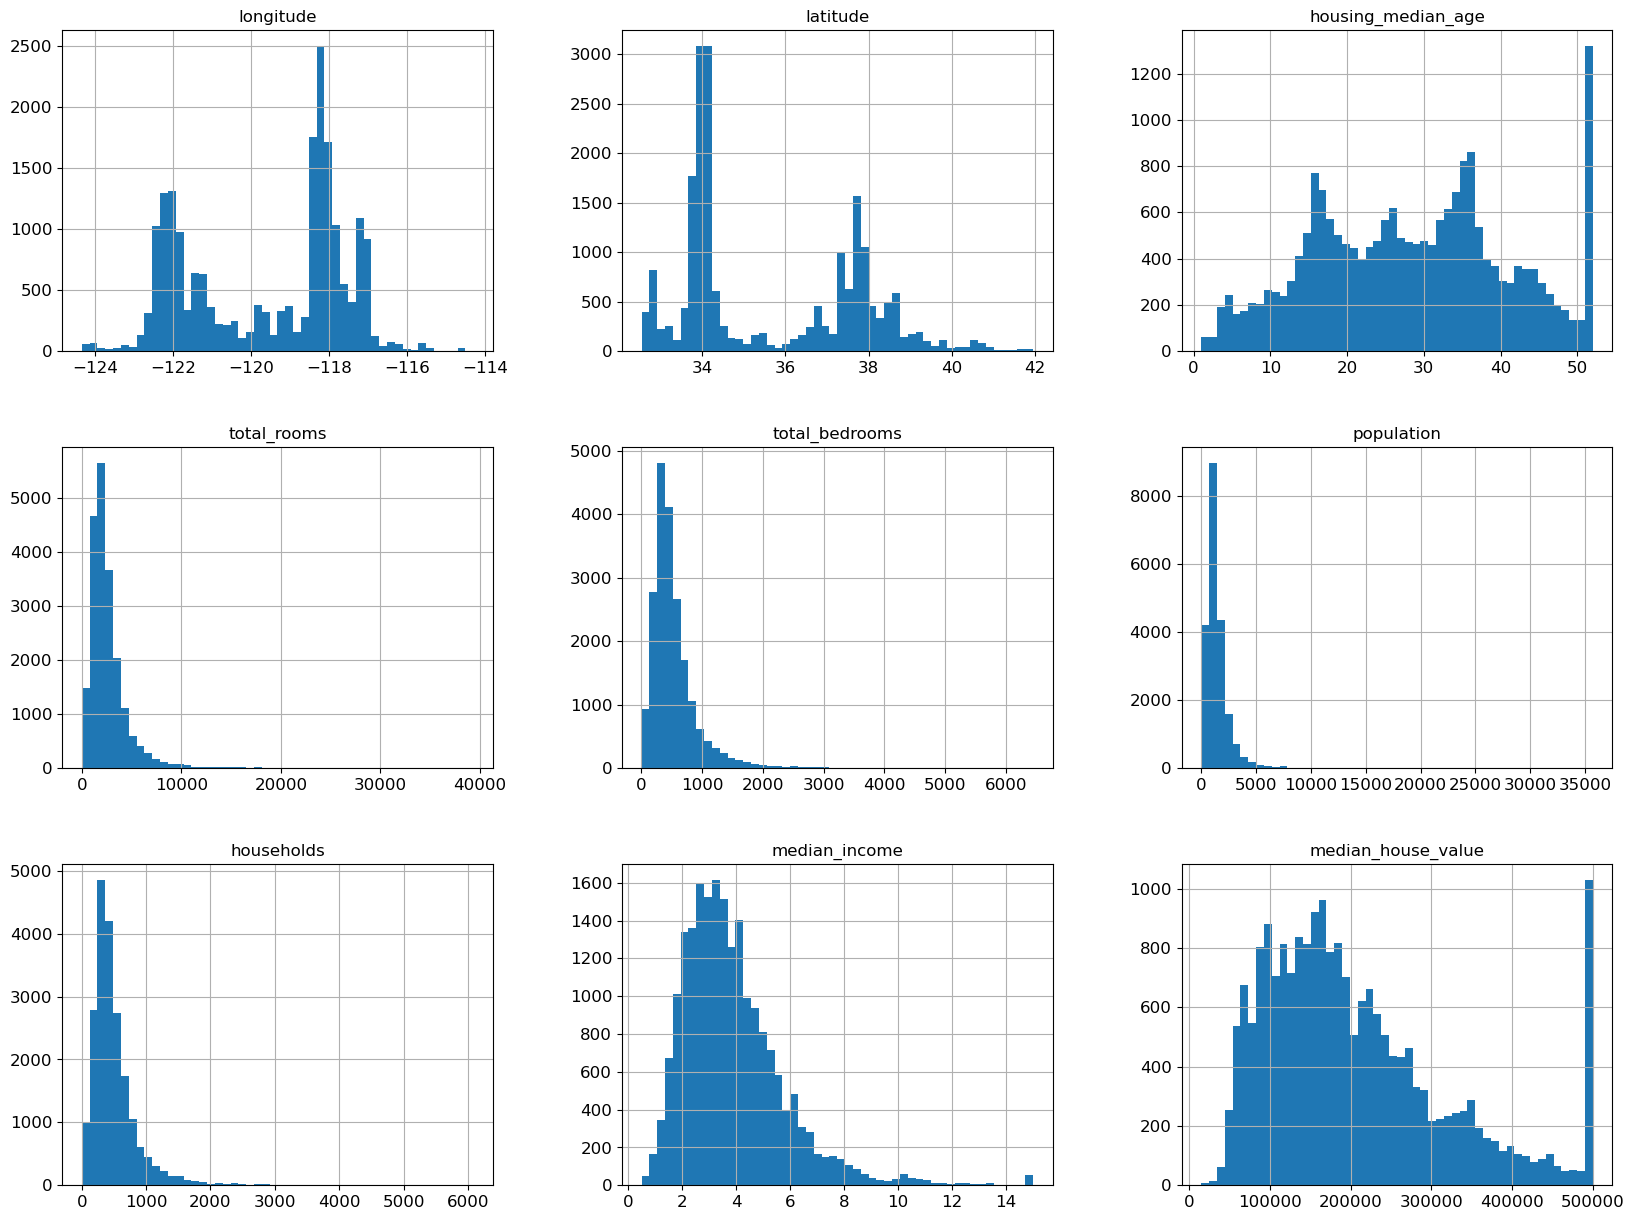

In [41]:
housing.hist(bins=50, figsize=(20,15));
plt.show();

# Descubriendo y visualiando los datos

## Visualizando datos geográficos

Simplemente vamos a hacer una gráfica de tipo $scatter$ de las columnas longitud y latitud.

<Axes: xlabel='longitude', ylabel='latitude'>

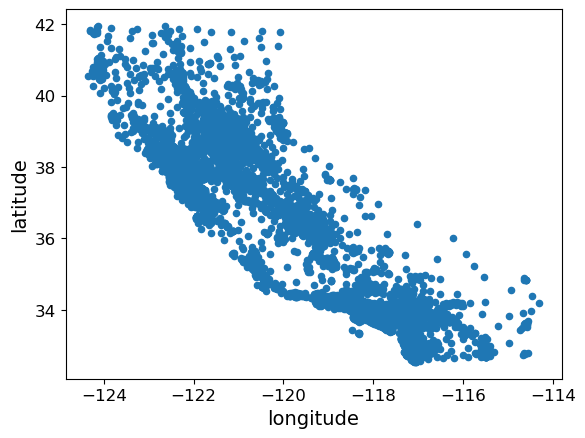

In [42]:
housing.plot(kind="scatter", x="longitude", y="latitude")


Para visualizar un poco mejor las diferentes densidades de los datos geogŕficos, vamos a darle un poco de transparencia a los puntos.

<Axes: xlabel='longitude', ylabel='latitude'>

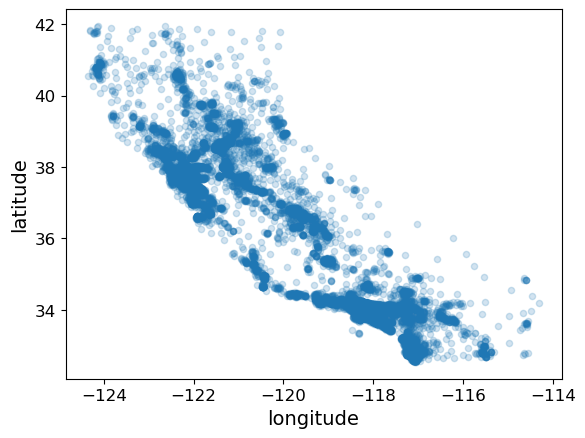

In [43]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.2)

<Axes: xlabel='longitude', ylabel='latitude'>

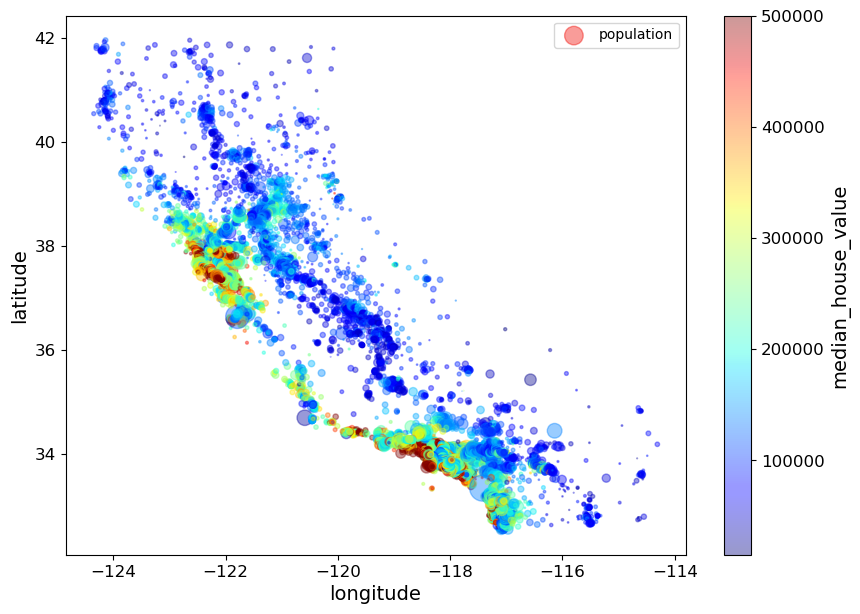

In [44]:
housing.plot(kind="scatter", 
             x="longitude", 
             y="latitude", 
             alpha=0.4,
             s=housing["population"]/100, 
             label="population", 
             figsize=(10,7),
             c="median_house_value", 
             cmap=plt.get_cmap("jet"), 
             colorbar=True,
             sharex=False)


Vamos a superponer los datos sobre un mapa real de la zona, ya que sabemos que es California y los datos están indexados en coordenadas geográficas (long/lat).


In [45]:
# https://jakevdp.github.io/PythonDataScienceHandbook/04.13-geographic-data-with-basemap.html

#!pip install pillow
#!pip install basemap
#!pip install basemap-data-hires


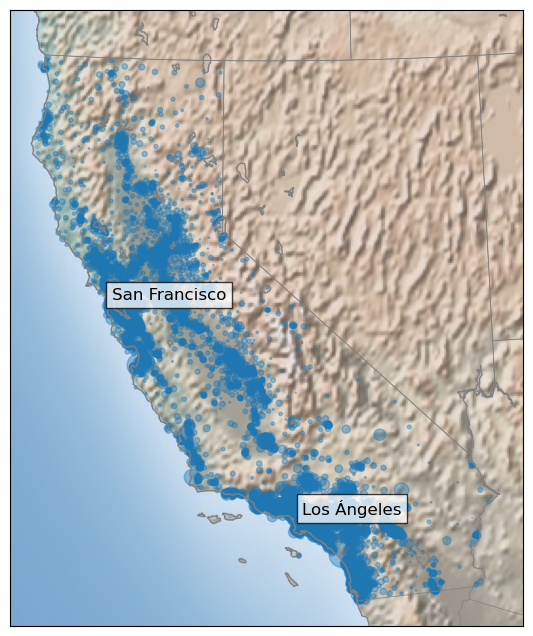

In [46]:
import mpl_toolkits
from mpl_toolkits.basemap import Basemap

fig = plt.figure(figsize=(8, 8))

m = Basemap(projection='lcc', 
            resolution='h', 
            lat_0=37.5, 
            lon_0=-119,
            width=1E6, 
            height=1.2E6)

m.shadedrelief()
m.drawcoastlines(color='gray')
m.drawcountries(color='gray')
m.drawstates(color='gray')

m.scatter(housing["longitude"],
          housing["latitude"],
          latlon=True,         
          s=housing["population"]/100, 
          alpha=0.40)

x, y = m(-118.243683, 34.052235)
plt.text(x, y, 'Los Ángeles', fontsize=12, bbox=dict(facecolor="white", alpha=0.75));

x, y = m(-122.431297, 37.773972)
plt.text(x, y, 'San Francisco', fontsize=12, bbox=dict(facecolor="white", alpha=0.75));


## A la búsqueda de correlaciones


In [49]:
dt2 = housing.copy()
dt2 = dt2.drop("ocean_proximity", axis=1)

# TABLA DE CORRELACIÓN
corr_matrix = dt2.corr()
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924664,-0.108197,0.044568,0.069608,0.099773,0.055310,-0.015176,-0.045967
latitude,-0.924664,1.000000,0.011173,-0.036100,-0.066983,-0.108785,-0.071035,-0.079809,-0.144160
housing_median_age,-0.108197,0.011173,1.000000,-0.361262,-0.320451,-0.296244,-0.302916,-0.119034,0.105623
total_rooms,0.044568,-0.036100,-0.361262,1.000000,0.930380,0.857126,0.918484,0.198050,0.134153
total_bedrooms,0.069608,-0.066983,-0.320451,0.930380,1.000000,0.877747,0.979728,-0.007723,0.049686
population,0.099773,-0.108785,-0.296244,0.857126,0.877747,1.000000,0.907222,0.004834,-0.024650
households,0.055310,-0.071035,-0.302916,0.918484,0.979728,0.907222,1.000000,0.013033,0.065843
median_income,-0.015176,-0.079809,-0.119034,0.198050,-0.007723,0.004834,0.013033,1.000000,0.688075
median_house_value,-0.045967,-0.144160,0.105623,0.134153,0.049686,-0.024650,0.065843,0.688075,1.000000


Centrémonos en las correlaciones de la columna a predecir ($median\_house\_value$) con el resto de columnas numéricas.

In [50]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

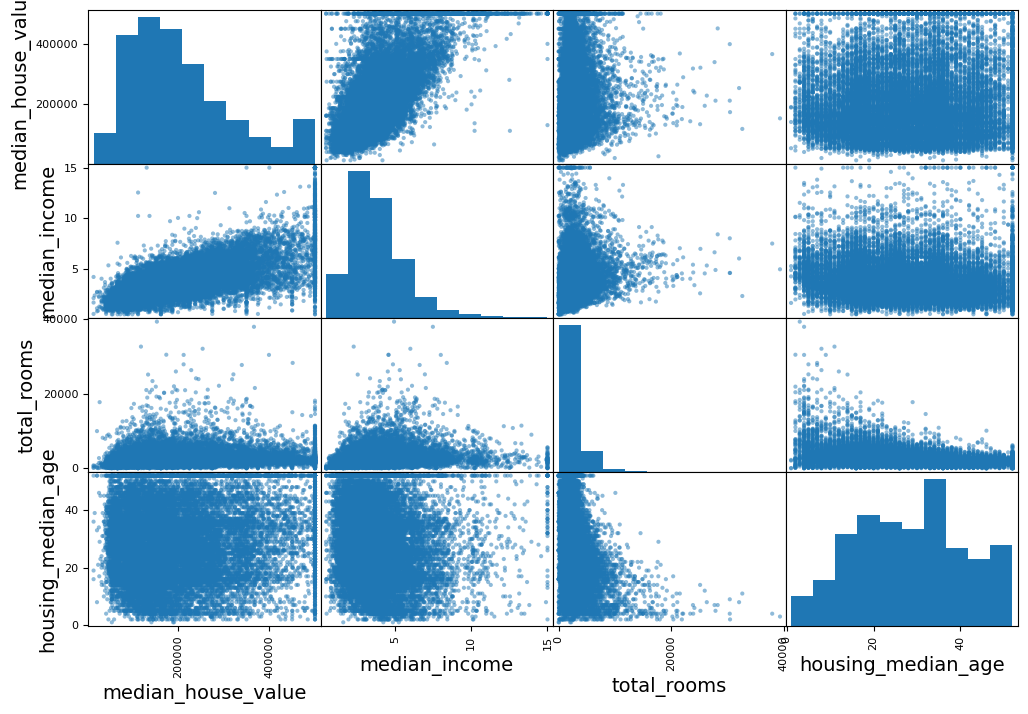

In [51]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8));


Miremos con más detenimiento la correlación del valor medio de las casas, con los ingresos medios de la zona. Hay una clara correlación (~0.7), aunque no una identidad (1).

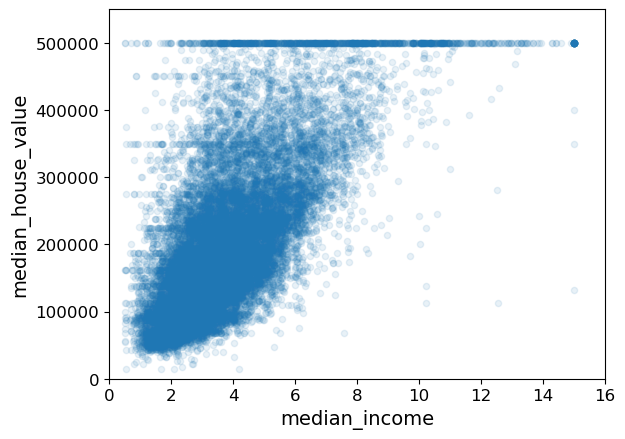

In [52]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1);
plt.axis([0, 16, 0, 550000]);


## Experimentando con operaciones con columnas

Siempre podemos buscar oro debajo de las piedras. Esto no significa que lo encontremos, pero quizá encontremos algo diferente y valioso. Las correlaciones ocultas son aquellas que no se muestran en los datos pero pueden aparecer cuando combinamos uno o más de las columnas en expresiones aritméticas.

Para saber qué operaciones hacer, consulta a los/las expertas en materia inmobiliaria.

In [53]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [55]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

Fíjate:
* Ha aparecido $rooms\_per\_household$ con un ídice de correlación superior al de sus precursoras.
* $bedrooms\_per\_room$ igualmente ha emergido con un índice de correlación alto y negativo, lo cual también ayuda.

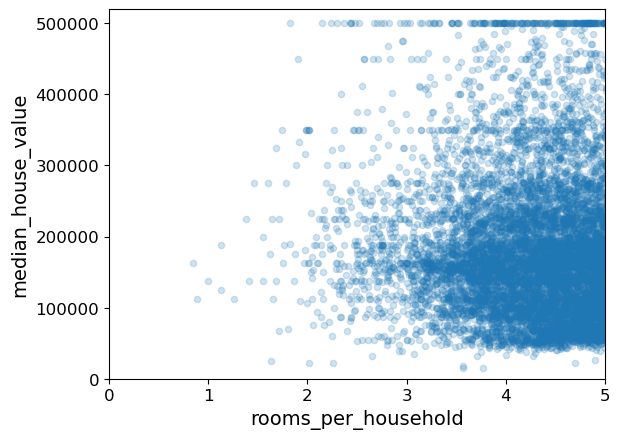

In [56]:
housing.plot(kind="scatter", x="rooms_per_household", y="median_house_value", alpha=0.2)
plt.axis([0, 5, 0, 520000])
plt.show()

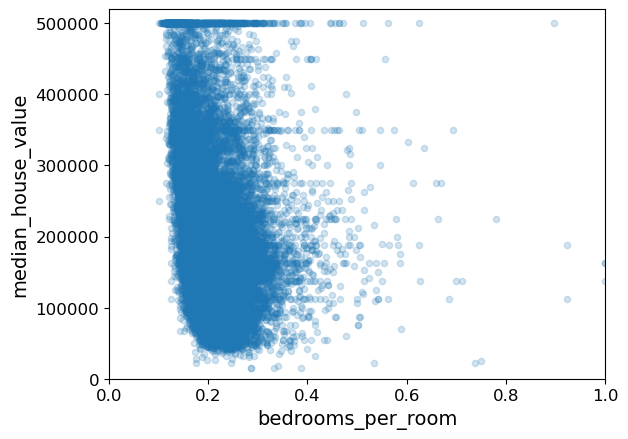

In [57]:
housing.plot(kind="scatter", x="bedrooms_per_room", y="median_house_value", alpha=0.2)
plt.axis([0, 1, 0, 520000])
plt.show()

In [58]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909,5.429000,0.213039,3.070655
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874,2.474173,0.057983,10.386050
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000,0.846154,0.100000,0.692308
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000,4.440716,0.175427,2.429741
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000,5.229129,0.203162,2.818116
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000,6.052381,0.239821,3.282261
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000,141.909091,1.000000,1243.333333


# Preparando los datos para el entrenamiendo del modelo

## Limpieza de datos

La columna $median\_income$, que representa los ingresos medios de los habitantes de la zona, parece estar en un formato numérico (una gradación de 0 a 15, parece). Vamos a transformarlo a una gradación de 5 grupos (de 1 a 5, sin decimales).

<Axes: >

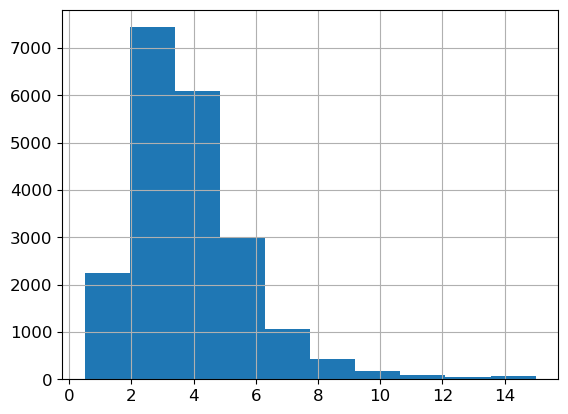

In [59]:
housing["median_income"].hist()

In [60]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0.0, 1.5, 3.0, 4.5, 6.0, np.inf],
                               labels=[1, 2, 3, 4, 5])

housing["income_cat"]=pd.to_numeric(housing["income_cat"]);

housing=housing.drop(["median_income"], axis=1);

In [61]:
housing["income_cat"].value_counts()

income_cat
3    7236
2    6581
4    3639
5    2362
1     822
Name: count, dtype: int64

Fijaros que los valores ahora están un poco más balanceados (dentro de las limitaciones de los datos) y las rentas altas están más agrupadas.

<Axes: >

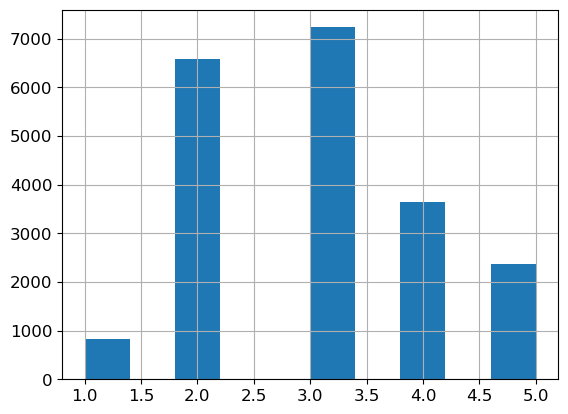

In [62]:
housing["income_cat"].hist()

In [63]:
housing["income_cat"].value_counts() / len(housing)

income_cat
3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: count, dtype: float64

¿Recuerdas que $total\_bedrooms$ tenía celdas **null**? 

¿Recuerdas que $ocean\_proximity$ era de tipo $string$?

**NOTA**: *en mi notebook he tenido la suerte de que todos los null caigan en el test_set*.

In [64]:
median = housing["total_bedrooms"].median()
housing["total_bedrooms"].fillna(median, inplace=True)

In [65]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
0,NEAR BAY
1,NEAR BAY
2,NEAR BAY
3,NEAR BAY
4,NEAR BAY
5,NEAR BAY
6,NEAR BAY
7,NEAR BAY
8,NEAR BAY
9,NEAR BAY


Tenemos dos posibilidades:

1. Codificar cada etiqueta de $ocean\_proximity$ como un número: con lo que estamos introduciendo información exterior, o
2. Hacer un OneHotEncoding ...

Lo que sigue es cómo asignar un número a cada etiqueda de $ocean\_proximity$

In [66]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[3.],
       [3.],
       [3.],
       [3.],
       [3.],
       [3.],
       [3.],
       [3.],
       [3.],
       [3.]])

Teniendo en este campo del objeto, la lista para poder recuperar el nombre de la etiqueta a partir del número.

In [67]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

Otra forma, mucho mejor, es crear tantas columnas como etiquetas diferentes tiene la columna categórica (en este caso 5) y poner 0 o 1 (false, true) si la instancia tiene o no dicha etiqueta.

Así no introducimos información nueva. Pero añadimos columnas.

In [68]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<20640x5 sparse matrix of type '<class 'numpy.float64'>'
	with 20640 stored elements in Compressed Sparse Row format>

Por defecto, `OneHotEncoder` devuelve un sparse array (array/matríz con muchos ceros y muy comprimible), pero podemos convertirlo a un array/matriz denso de la siguiente manera:

In [69]:
housing_cat_1hot.toarray()

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

También se lo podíamos indicar en los parámetros: `sparse=False`:

In [70]:
cat_encoder = OneHotEncoder(sparse=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

c:\Users\diego.guizanlopez\AppData\Local\miniconda3\envs\ia\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [71]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

Ahora podemos sustituir la columna `ocean_proximity` por sus `OneHotEncoder`.

In [72]:
housing.reset_index(drop=False, inplace=True)
housing=housing.join(pd.DataFrame(housing_cat_1hot, columns=[cat for cat in cat_encoder.categories_[0]]))
housing=housing.drop(["ocean_proximity"], axis=1);
housing=housing.rename({"<1H OCEAN":"1H OCEAN"}, axis=1)
housing.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   index                     20640 non-null  int64  
 1   longitude                 20640 non-null  float64
 2   latitude                  20640 non-null  float64
 3   housing_median_age        20640 non-null  float64
 4   total_rooms               20640 non-null  float64
 5   total_bedrooms            20640 non-null  float64
 6   population                20640 non-null  float64
 7   households                20640 non-null  float64
 8   median_house_value        20640 non-null  float64
 9   rooms_per_household       20640 non-null  float64
 10  bedrooms_per_room         20433 non-null  float64
 11  population_per_household  20640 non-null  float64
 12  income_cat                20640 non-null  int64  
 13  1H OCEAN                  20640 non-null  float64
 14  INLAND

## Creamos el Test Set

Entramos a crear los datos necesarios para el entrenamiento y la evaluación del modelo.

Como vamos a trabajar con numeros aleatorios, plantaremos una semilla estocástica, esto es, vamos a inicializar el generador de números aleatorios con un número, de tal forma que siempre nos proporcionará la misma secuencia de números aleatorios si empezamos con la misma semilla.

In [73]:
# ¿por qué 42? https://es.wikipedia.org/wiki/El_sentido_de_la_vida,_el_universo_y_todo_lo_demás
np.random.seed(42);

La siguiente función se encarga de dividir (split) los datos en dos subconjuntos con un ratio indicado (80%, 20% por ejemplo).

Aurélien lo hace de forma un poco,... enrevesada, pero muy efectiva:

1. Primero obtiene una permutación de los índices (*shuffled*=barajado).
2. Para después quedarse con un porcentaje para el **train set** y el restante para el **test set**.
3. La función devuelve ambos conjuntos de datos.


In [74]:
# divide los datos en train y set sets.
def split_train_test(data, test_ratio):
    # https://numpy.org/doc/stable/reference/random/generated/numpy.random.permutation.html
    shuffled_indices = np.random.permutation(len(data)); 
    test_set_size = int(len(data) * test_ratio);
    test_indices = shuffled_indices[:test_set_size];
    train_indices = shuffled_indices[test_set_size:];
    return data.iloc[train_indices], data.iloc[test_indices];

Seguidamente usamos la función y mostramos el tamaño de cada conjunto separado de los datos iniciales.

In [75]:
X_train, X_test = split_train_test(housing, 0.2)
len(X_train)

16512

In [76]:
len(X_test)

4128

In [77]:
X_test.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household,income_cat,1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
20046,20046,-119.01,36.06,25.0,1505.0,435.0,1392.0,359.0,47700.0,4.192201,NaN,3.877437,2,0.0,1.0,0.0,0.0,0.0
3024,3024,-119.46,35.14,30.0,2943.0,435.0,1565.0,584.0,45800.0,5.039384,NaN,2.679795,2,0.0,1.0,0.0,0.0,0.0
15663,15663,-122.44,37.80,52.0,3830.0,435.0,1310.0,963.0,500001.0,3.977155,NaN,1.360332,3,0.0,0.0,0.0,1.0,0.0
20484,20484,-118.72,34.28,17.0,3051.0,435.0,1705.0,495.0,218600.0,6.163636,NaN,3.444444,4,1.0,0.0,0.0,0.0,0.0
9814,9814,-121.93,36.62,34.0,2351.0,435.0,1063.0,428.0,278000.0,5.492991,NaN,2.483645,3,0.0,0.0,0.0,0.0,1.0


Volvemos al **train set**. 
* Para trabajar con los datos, con el objetivo de entrenar un modelo, primero separamos las columnas predictoras de la columna a predecir ($housing$ y $housing\_labels$)
* Para después hacer limpieza de los primeros.

In [78]:
y_train = X_train["median_house_value"].copy();
X_train = X_train.drop("median_house_value", axis=1);


# Seleccionar y entrenar el modelo

## Entrenando y evaluando el modelo de **train_set**

**Regresión lineal multivariable**

In [79]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression()

In [80]:
some_data = X_train.iloc[:5]
print("Predictions:", lin_reg.predict(some_data))

some_labels = y_train.iloc[:5]
print("Labels:", list(some_labels))

Predictions: [210112.60160566 290080.10905652 237434.87979008 160676.41032696
 169806.0889646 ]
Labels: [103000.0, 382100.0, 172600.0, 93400.0, 96500.0]


In [81]:
from sklearn.metrics import mean_squared_error

predictions = lin_reg.predict(X_train)
lin_mse = mean_squared_error(y_train, predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

72466.29596009899

In [82]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(y_train, predictions)
lin_mae

54496.70804419881

**Decision Tree**

In [83]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [84]:
predictions = tree_reg.predict(X_train)
tree_mse = mean_squared_error(y_train, predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

**Error 0!!!**

Pero no cantemos victoria. Estamos evaluando contra el mismo dataset que hemos empleado para entrenar el modelo. 

Esto es, básicamente, hacer trampa.

## Usando la Cross-Validation

Vamos a usar un medio de evaluación del modelo sin usar -aún- el testset.

In [85]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, X_train, y_train, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [86]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [69900.27555949 69917.29334119 66818.61867301 68875.61264955
 71540.74537282 68474.65840833 69822.75606482 69345.03237611
 68476.39072897 67367.21370266]
Mean: 69053.85968769508
Standard deviation: 1298.6267626066976


In [87]:
lin_scores = cross_val_score(lin_reg, X_train, y_train, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [69956.90125981 76664.26551146 70495.35619822 70738.05620993
 73347.14098355 71020.33855508 70921.19634339 71362.91940785
 77049.90056676 75205.43946791]
Mean: 72676.15145039753
Standard deviation: 2556.067776637088


**Random Forest**

In [88]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [89]:
predictions = forest_reg.predict(X_train)
forest_mse = mean_squared_error(y_train, predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

18316.335844790185

In [90]:
forest_scores = cross_val_score(forest_reg, X_train, y_train, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [47793.68220893 50027.4114661  48079.47384622 50472.79453833
 51113.01982409 48116.39511355 49514.29541387 50601.80185073
 48772.37925606 50003.75485174]
Mean: 49449.500836960266
Standard deviation: 1124.3653045576818


El mejor de los que hemos probado.

**Support Vector Regression**

In [91]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(X_train, y_train)
predictions = svm_reg.predict(X_train)
svm_mse = mean_squared_error(y_train, predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

100212.13117406932

**XGBoost**

In [92]:
import xgboost as xgb

xgb_reg = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)
xgb_reg.fit(X_train, y_train)
predictions = xgb_reg.predict(X_train)
xgb_mse = mean_squared_error(y_train, predictions)
xgb_rmse = np.sqrt(xgb_mse)
xgb_rmse


26662.971571219874

In [93]:
xgb_scores = cross_val_score(xgb_reg, X_train, y_train, scoring="neg_mean_squared_error", cv=10)
xgb_rmse_scores = np.sqrt(-xgb_scores)
display_scores(xgb_rmse_scores)

Scores: [44592.83932085 48348.8088162  45960.95731453 47838.04333711
 47644.52694816 46005.86482441 46315.19655226 46736.32587257
 47058.76963862 46709.71945275]
Mean: 46721.10520774675
Standard deviation: 1031.878251144249


## Evaluando el modelo con el test set

Quizá habría que repetir todo el proceso de limpieza y adaptación que hicimos anteriormente con el train set. En nuestro caso, sólo un campo se nos quedó olvidado.

In [94]:
y_test = X_test["median_house_value"].copy()
X_test = X_test.drop("median_house_value", axis=1)

median = X_test["bedrooms_per_room"].median()
X_test["bedrooms_per_room"].fillna(median, inplace=True)


In [95]:
predictions = tree_reg.predict(X_test)

final_mse = mean_squared_error(y_test, predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

67143.56517183171